In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile as zf
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   #使用GPU训练模型

In [4]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, 
    upsample=None, instance_norm=True, relu=True):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1), 
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x

In [5]:
class TransformNet(nn.Module):
    def __init__(self, base=32):
        super(TransformNet, self).__init__()
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9), 
            *ConvLayer(base, base*2, kernel_size=3, stride=2), 
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2), 
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False),
        )
    
    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

In [19]:
def Transfer(style_state,transfer_img,output_path):
  transform =TransformNet(32).to(device)
  transform.load_state_dict(torch.load(style_state,map_location=lambda storage, loc: storage))
  transform.eval()

  content_image = torchvision.datasets.folder.default_loader(transfer_img)
  content_transform = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
      ])
  content_image = content_transform(content_image)
  content_image = content_image.unsqueeze(0).to(device)

  output_img = transform(content_image)

  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 2)
  imshow(content_image, title='Content Image')

  plt.subplot(1, 3, 3)
  imshow(output_img.detach(), title='Output Image')

  output_data = output_img.cpu().data[0]
  torchvision.utils.save_image(((output_data / 255)).clamp(min=0, max=1), output_path)

(650, 648, 3)
(652, 648, 3)


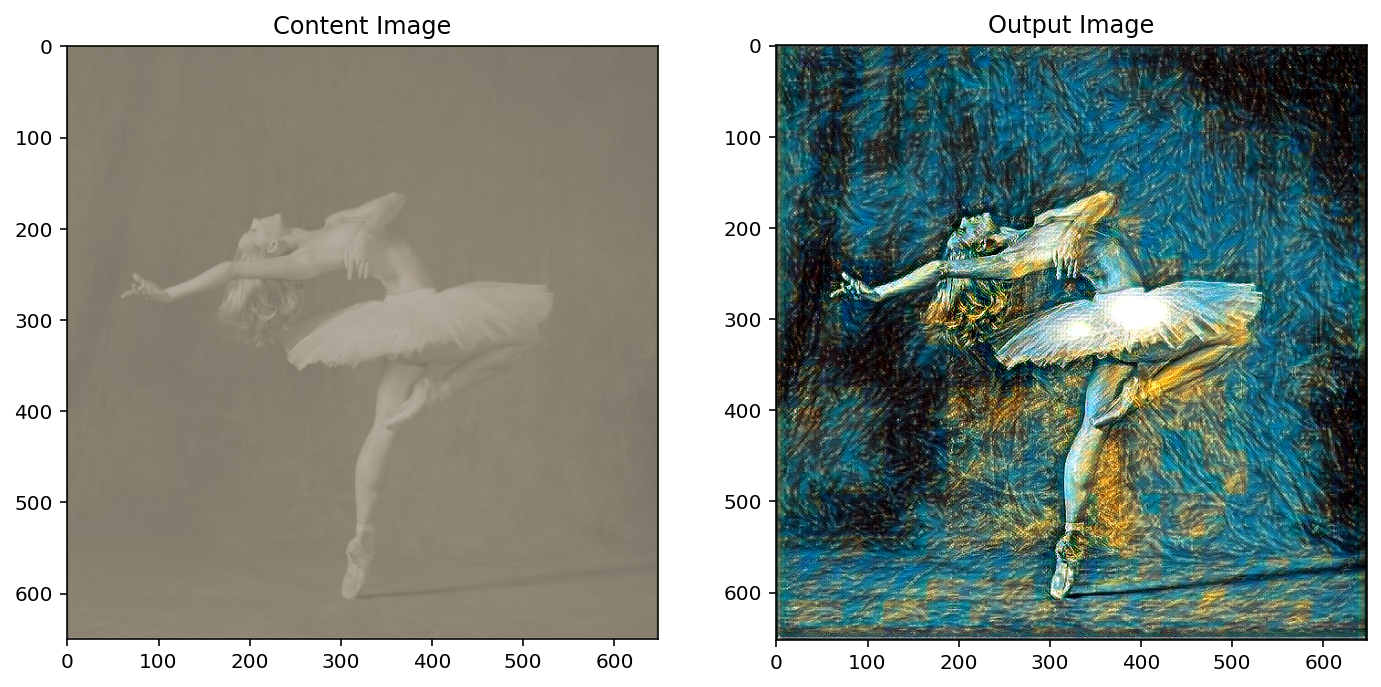

In [20]:
# Transfer('transform_net_starry_night3.pth','target2.png','output.jpg')